In [1]:
import json
import joblib
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    MarianMTModel, MarianTokenizer
)
import glob
from sklearn.metrics import classification_report, accuracy_score, f1_score

c:\Users\saraujo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import pandas as pd
import numpy as np
import torch

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.utils.multiclass import unique_labels

In [4]:
import nltk
# nltk.download('averaged_perceptron_tagger_eng')

In [5]:
import spacy
from nltk.corpus import stopwords
import string

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\saraujo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
!python -m spacy download es_core_news_lg

     ---------------------------------------- 0.0/568.0 MB ? eta -:--:--
     ---------------------------------------- 0.3/568.0 MB ? eta -:--:--
     ---------------------------------------- 1.3/568.0 MB 5.2 MB/s eta 0:01:50
     ---------------------------------------- 2.9/568.0 MB 6.2 MB/s eta 0:01:31
     ---------------------------------------- 3.4/568.0 MB 5.3 MB/s eta 0:01:47
     ---------------------------------------- 3.7/568.0 MB 4.4 MB/s eta 0:02:10
     ---------------------------------------- 3.9/568.0 MB 3.9 MB/s eta 0:02:25
     ---------------------------------------- 5.0/568.0 MB 3.8 MB/s eta 0:02:30
     ---------------------------------------- 6.6/568.0 MB 4.2 MB/s eta 0:02:13
      --------------------------------------- 7.9/568.0 MB 4.5 MB/s eta 0:02:05
      --------------------------------------- 9.4/568.0 MB 4.8 MB/s eta 0:01:57
      -------------------------------------- 10.5/568.0 MB 4.9 MB/s eta 0:01:55
      -------------------------------------- 12.1/568.


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
nlp = spacy.load("es_core_news_lg")

In [9]:
stopwords_es = set(stopwords.words('spanish'))
stopwords_en = set(stopwords.words('english'))
stop_words = stopwords_es | stopwords_en

In [10]:
# Función de limpieza y lematización
def procesar_texto(texto):
    if texto is None or texto.strip() == "":
        return ""
    # Unicode, minúsculas, quitar puntuación
    texto = texto.lower().translate(str.maketrans('', '', string.punctuation))
    # Procesar con spaCy
    doc = nlp(texto)
    # Lematizar y quitar stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and not token.is_punct and not token.is_space]
    return " ".join(tokens)

# Unir columnas y procesar
def crear_corpus(row):
    return procesar_texto(str(row))

In [ ]:
class ModelLoader:
    """Clase para cargar y usar modelos guardados"""

    def __init__(self, models_dir="./models/"):
        self.models_dir = models_dir
        self.loaded_models = {}

    def list_available_models(self):
        """Lista todos los modelos disponibles"""
        print("📋 Modelos disponibles:")

        # Modelos tradicionales
        traditional_dir = f"{self.models_dir}/traditional"
        if os.path.exists(traditional_dir):
            print("\\n🤖 Modelos Tradicionales:")
            for model_folder in os.listdir(traditional_dir):
                model_path = f"{traditional_dir}/{model_folder}"
                if os.path.isdir(model_path):
                    metadata_path = f"{model_path}/metadata.json"
                    if os.path.exists(metadata_path):
                        with open(metadata_path, 'r') as f:
                            metadata = json.load(f)
                        print(f"   - {model_folder}")
                        print(f"     Accuracy: {metadata['test_accuracy']:.4f}")
                        print(f"     F1-Score: {metadata['test_f1']:.4f}")

        # Modelos transformer
        transformer_dir = f"{self.models_dir}/transformers"
        if os.path.exists(transformer_dir):
            print("\\n🚀 Modelos Transformer:")
            for model_folder in os.listdir(transformer_dir):
                model_path = f"{transformer_dir}/{model_folder}"
                if os.path.isdir(model_path):
                    metadata_path = f"{model_path}/metadata.json"
                    if os.path.exists(metadata_path):
                        with open(metadata_path, 'r') as f:
                            metadata = json.load(f)
                        print(f"   - {model_folder}")
                        print(f"     Accuracy: {metadata['test_accuracy']:.4f}")
                        print(f"     F1-Score: {metadata['test_f1']:.4f}")
                        print(f"     GPU: {metadata['gpu_used']}")

    def load_traditional_model(self, model_folder):
        """Carga modelo tradicional"""
        model_dir = f"{self.models_dir}/traditional/{model_folder}"

        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Modelo no encontrado: {model_dir}")

        print(f"📥 Cargando modelo tradicional: {model_folder}")

        # Cargar componentes
        model_path = f"{model_dir}/model.pkl"
        vectorizer_path = f"{model_dir}/vectorizer.pkl"
        metadata_path = f"{model_dir}/metadata.json"
        label_path = f"{model_dir}/label_encoder.pkl"

        model = joblib.load(model_path)
        vectorizer = joblib.load(vectorizer_path)
        label_encoder = joblib.load(label_path)

        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        # Guardar en cache
        self.loaded_models[model_folder] = {
            'type': 'traditional',
            'model': model,
            'vectorizer': vectorizer,
            'label_encoder': label_encoder,
            'metadata': metadata
        }

        print(f"   ✅ Modelo cargado exitosamente")
        print(f"   📊 Test Accuracy: {metadata['test_accuracy']:.4f}")

        return model, vectorizer, metadata, label_encoder

    def load_transformer_model(self, model_folder, device=None):
        """Carga modelo transformer"""
        model_dir = f"{self.models_dir}/transformers/{model_folder}"

        if not os.path.exists(model_dir):
            raise FileNotFoundError(f"Modelo no encontrado: {model_dir}")

        print(f"📥 Cargando modelo transformer: {model_folder}")

        # Detectar dispositivo
        if device is None:
            if torch.cuda.is_available():
                device = "cuda"
            elif torch.backends.mps.is_available():
                device = "mps"
            else:
                device = "cpu"

        print(f"   🔧 Usando dispositivo: {device}")

        # Cargar componentes
        label_path = f"{model_dir}/label_encoder.pkl"
        label_encoder = joblib.load(label_path)

        metadata_path = f"{model_dir}/metadata.json"
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        tokenizer = AutoTokenizer.from_pretrained(model_dir)
        model = AutoModelForSequenceClassification.from_pretrained(model_dir)
        model = model.to(device)
        model.eval()

        # Guardar en cache
        self.loaded_models[model_folder] = {
            'type': 'transformer',
            'model': model,
            'tokenizer': tokenizer,
            'metadata': metadata,
            'label_encoder': label_encoder,
            'device': device
        }

        print(f"   ✅ Modelo cargado exitosamente")
        print(f"   📊 Test Accuracy: {metadata['test_accuracy']:.4f}")

        return model, tokenizer, metadata, label_encoder

    def predict_traditional(self, model_folder, texts):
        """Predicción con modelo tradicional"""
        if model_folder not in self.loaded_models:
            self.load_traditional_model(model_folder)

        model_data = self.loaded_models[model_folder]
        model = model_data['model']
        vectorizer = model_data['vectorizer']

        print(f"🔍 Procesando {len(texts)} textos para predicción...")
        new_list_lema = []
        for text in texts:
            new_list_lema.append(crear_corpus(text))

        # Vectorizar textos
        X_vec = vectorizer.transform(new_list_lema)

        # Predicciones
        predictions = model.predict(X_vec)
        probabilities = None

        # Obtener probabilidades si el modelo las soporta
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(X_vec)

        # Convertir de numpy a listas antes de retornar
        predictions_list = predictions.tolist() if hasattr(predictions, 'tolist') else predictions
        probabilities_list = probabilities.tolist() if probabilities is not None and hasattr(probabilities, 'tolist') else probabilities

        # return predictions, probabilities
        return predictions_list, probabilities_list

    def predict_transformer(self, model_folder, texts, batch_size=16):
        print(f"🔍 Cargando modelo transformer: {model_folder}")
        """Predicción con modelo transformer"""
        if model_folder not in self.loaded_models:
            self.load_transformer_model(model_folder)

        model_data = self.loaded_models[model_folder]
        model = model_data['model']
        tokenizer = model_data['tokenizer']
        device = model_data['device']

        print(f"🔍 Procesando {len(texts)} textos para predicción...")
        new_list_lema = []
        for text in texts:
            new_list_lema.append(crear_corpus(text))

        predictions = []
        probabilities = []

        # Procesar en lotes
        for i in range(0, len(new_list_lema), batch_size):
            batch_texts = new_list_lema[i:i+batch_size]

            # Tokenizar
            inputs = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            )

            # Mover al dispositivo
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Predicción
            with torch.no_grad():
                outputs = model(**inputs)
                logits = outputs.logits

                # Probabilidades
                probs = torch.softmax(logits, dim=-1)
                probabilities.extend(probs.cpu().numpy())

                # Predicciones
                preds = torch.argmax(logits, dim=-1)
                predictions.extend(preds.cpu().numpy())

        # Convertir a lista y entero cada elemento interno de predictions y probabilities        
        tmp_predictions = predictions.copy()
        for i, pred in enumerate(tmp_predictions):
            predictions[i] = int(pred)
            probabilities[i] = probabilities[i].tolist() if probabilities is not None else None
        
        return predictions, probabilities


# test

In [12]:
def read_csv_dataset(file_path):
    """Lee un dataset en formato CSV y lo convierte a DataFrame de pandas"""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")

    df = pd.read_csv(file_path)

    # Verificar que tenga las columnas esperadas
    if 'text' not in df.columns or 'label' not in df.columns:
        raise ValueError("El archivo CSV debe contener las columnas 'text' y 'label'")

    return df[['text', 'label']]

In [115]:
"""Función principal - Ejemplos de uso"""
print("🎯 SDG Classifier - Inferencia con Modelos Guardados")

# Inicializar cargador de modelos
loader = ModelLoader()

# Listar modelos disponibles
loader.list_available_models()

🎯 SDG Classifier - Inferencia con Modelos Guardados
📋 Modelos disponibles:
\n🤖 Modelos Tradicionales:
   - LinearSVC_20250804_100249
     Accuracy: 0.8622
     F1-Score: 0.8585
   - Logistic_Regression_20250804_100551
     Accuracy: 0.9095
     F1-Score: 0.9090
   - Random_Forest_20250804_100503
     Accuracy: 0.9414
     F1-Score: 0.9413
   - XGBoost_20250804_101658
     Accuracy: 0.8579
     F1-Score: 0.8581
\n🚀 Modelos Transformer:
   - bert_20250806_234119
     Accuracy: 0.9026
     F1-Score: 0.9017
     GPU: True
   - distilbert_20250806_152834
     Accuracy: 0.8407
     F1-Score: 0.8390
     GPU: True


In [116]:
def predict_single_texts(model_loader, model_folder, texts, model_type='auto'):
    """Predice etiquetas para textos individuales"""
    print(f"\\n🔮 Prediciendo {len(texts)} textos con modelo: {model_folder}")

    # Detectar tipo de modelo
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                print(f"{model_loader.models_dir}/traditional/{model_folder}")
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                print(f"{model_loader.models_dir}/transformers/{model_folder}")
                model_type = 'transformer'

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
        print("Types", type(predictions), type(probabilities))
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)
        print("Types", type(predictions), type(probabilities))

    # Mostrar resultados
    print("\\n📋 Resultados:")
    for i, (text, pred) in enumerate(zip(texts, predictions)):
        prob_str = ""
        if probabilities is not None:
            max_prob = np.max(probabilities[i])
            prob_str = f" (confianza: {max_prob:.3f})"

        print(f"   {i+1}. Texto: '{text[:50]}...'")
        print(f"      Predicción: {pred}{prob_str}")

    return predictions, probabilities

In [117]:
# Ejemplo 1: Predicción de textos individuales
print("\\n" + "="*60)
print("EJEMPLO 1: Predicción de textos individuales")

sample_texts = [
    "This project focuses on clean water and sanitation for rural communities",
    # "The initiative aims to reduce poverty through microfinance programs",
    # "Our research addresses climate change mitigation strategies"
]

# Nota: Reemplaza con el nombre real de tu modelo
# predictions, probs = predict_single_texts(loader, "Random_Forest_20250804_100503", sample_texts)
predictions, probs = predict_single_texts(loader, "bert_20250806_234119", sample_texts)


\n============================================================
EJEMPLO 1: Predicción de textos individuales
\n🔮 Prediciendo 1 textos con modelo: bert_20250806_234119
./models//transformers/bert_20250806_234119
🔍 Cargando modelo transformer: bert_20250806_234119
📥 Cargando modelo transformer: bert_20250806_234119
   🔧 Usando dispositivo: cpu
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.9026
🔍 Procesando 1 textos para predicción...
predictions [np.int64(10)]
predictions <class 'list'>
probabilities [array([0.00361448, 0.07550278, 0.02116306, 0.00146393, 0.00756059,
       0.00349196, 0.0151207 , 0.02644474, 0.00129017, 0.07608625,
       0.20200768, 0.02683145, 0.01433575, 0.00118091, 0.11315049,
       0.01403034, 0.11974687, 0.00558963, 0.00858246, 0.03217662,
       0.00153829, 0.00392741, 0.00369136, 0.03602557, 0.0379477 ,
       0.01497253, 0.00541833, 0.00324894, 0.01397176, 0.00386468,
       0.00818443, 0.03409093, 0.04889296, 0.01485429], dtype=float32)]
probabilities

In [16]:
def evaluate_on_dataset(model_loader, model_folder, dataset_path, text_column='text',
                       label_column='label', model_type='auto'):
    """Evalúa un modelo en un dataset completo"""
    print(f"\\n📊 Evaluando modelo en dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        df = read_csv_dataset(dataset_path)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    texts = df[text_column].astype(str).tolist()

    print(f"   📈 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            # Intentar detectar por la estructura de carpetas
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)

    label_encoder = model_loader.loaded_models[model_folder]['label_encoder']
    true_labels = df[label_column].apply(lambda x: label_encoder.transform([x])[0] if isinstance(x, str) else 0) # lleva el texto a su etiqueta numérica

    # Calcular métricas
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\\n📊 Resultados de evaluación:")
    print(f"   🎯 Accuracy: {accuracy:.4f}")
    print(f"   📈 F1-Score: {f1:.4f}")

    # Reporte detallado
    print(f"\\n📋 Reporte de clasificación:")
    print(classification_report(true_labels, predictions, zero_division=0))

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'probabilities': probabilities,
        'true_labels': true_labels
    }

In [ ]:
# Ejemplo 2: Evaluación en dataset
print("\\n" + "="*60)
print("EJEMPLO 2: Evaluación en dataset completo")
# results = evaluate_on_dataset(loader, "Random_Forest_20250804_100503", './data/dataset_test.csv')
results = evaluate_on_dataset(loader, "bert_20250806_234119", './data/dataset_test.csv')
# print("Para usar: ")

\n============================================================
EJEMPLO 2: Evaluación en dataset completo
\n📊 Evaluando modelo en dataset: ./data/dataset_test.csv
   📈 Dataset cargado: 20 muestras
🔍 Cargando modelo transformer: distilbert_20250806_152834
📥 Cargando modelo transformer: distilbert_20250806_152834
   🔧 Usando dispositivo: cpu


c:\Users\saraujo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.8407
🔍 Procesando 20 textos para predicción...
\n📊 Resultados de evaluación:
   🎯 Accuracy: 0.4000
   📈 F1-Score: 0.4895
\n📋 Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.25      0.40         4
           5       0.00      0.00      0.00         0
           6       1.00      0.50      0.67         2
           7       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          18       1.00      0.75      0.86         8
          19       0.00      0.00      0.00         1
          23       0.00      0.00      0.00         0
          32       0.00      0.00    

In [18]:
results["predictions"]

[18, 32, 15, 23, 15, 1, 18, 16, 23, 32, 5, 6, 15, 18, 18, 2, 18, 15, 15, 18]

In [19]:
results["true_labels"]

0     18
1     19
2      7
3     14
4      9
5      9
6     18
7      2
8      2
9     10
10     2
11     6
12     6
13    18
14    18
15     2
16    18
17    18
18    18
19    18
Name: label, dtype: int64

In [20]:
def generate_confusion_matrix(model_loader, model_folder, dataset_path, text_column='text',
                            label_column='label', model_type='auto',
                            save_plot=False, plot_filename=None, figsize=(8, 6)):
    """
    Genera y visualiza una matriz de confusión para un modelo en un dataset completo

    Args:
        model_loader: Instancia del cargador de modelos
        model_folder: Nombre de la carpeta del modelo
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        model_type: Tipo de modelo ('auto', 'traditional', 'transformer')
        save_plot: Si guardar el gráfico como archivo (default: False)
        plot_filename: Nombre del archivo para guardar (default: None)
        figsize: Tamaño de la figura (default: (8, 6))

    Returns:
        dict: Diccionario con métricas y matriz de confusión
    """

    print(f"\n🔍 Generando matriz de confusión para: {model_folder}")
    print(f"   📁 Dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        try:
            df = read_csv_dataset(dataset_path, only_first_label=True, only_last_label=False)
        except:
            df = pd.read_csv(dataset_path)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    texts = df[text_column].astype(str).tolist()

    print(f"   📊 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            # Intentar detectar por la estructura de carpetas
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")

    # Hacer predicciones
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)

    predictions = [str(label) for label in predictions]

    label_encoder = model_loader.loaded_models[model_folder]['label_encoder']
    true_labels = df[label_column].apply(lambda x: str(label_encoder.transform([x])[0]) if isinstance(x, str) else 0) # lleva el texto a su etiqueta numérica
    
    class_names = label_encoder.classes_
    set_labels = list(set(true_labels) | set(predictions))
    new_class_names_only_presents = [] # para la matriz de confusión, que muestre solo las etiquetas presentes
    for label_tmp in set_labels:
        new_class_names_only_presents.append(class_names[int(label_tmp)])

    # Asegurar que ambos sean del mismo tipo (soluciona el error de tipos mixtos)
    true_labels = [str(label) for label in true_labels]

    # Obtener etiquetas únicas para la matriz
    labels = sorted(unique_labels(true_labels, predictions))

    # Generar matriz de confusión
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    # Calcular métricas básicas
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"\n📈 Métricas del modelo:")
    print(f"   🎯 Accuracy: {accuracy:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")

    # Crear visualización de la matriz de confusión
    plt.figure(figsize=figsize)

    # Usar seaborn para una visualización más bonita
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=new_class_names_only_presents,
                yticklabels=new_class_names_only_presents,
                cbar_kws={'label': 'Número de muestras'})

    plt.title(f'Matriz de Confusión - {model_folder}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicciones', fontsize=12)
    plt.ylabel('Etiquetas Verdaderas', fontsize=12)
    plt.tight_layout()

    # Guardar si se solicita
    if save_plot:
        if plot_filename is None:
            plot_filename = f"./imgs/confusion_matrix_{model_folder}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"   💾 Matriz guardada como: {plot_filename}")

    plt.show()

    # Mostrar estadísticas adicionales de la matriz
    print(f"\n📋 Estadísticas de la Matriz de Confusión:")
    print(f"   📊 Forma de la matriz: {cm.shape}")
    print(f"   🏷️  Etiquetas encontradas: {labels}")
    print(f"   📈 Total de predicciones: {cm.sum()}")

    # Mostrar matriz en formato tabular
    print(f"\n📊 Matriz de Confusión (formato tabla):")
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = 'Verdadero'
    cm_df.columns.name = 'Predicho'
    print(cm_df)

    return {
        'confusion_matrix': cm,
        'labels': labels,
        'accuracy': accuracy,
        'f1_score': f1,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities,
        'confusion_matrix_df': cm_df
    }

\n============================================================
EJEMPLO 3: Matriz de Confusión y Comparación de Modelos

🔍 Generando matriz de confusión para: distilbert_20250806_152834
   📁 Dataset: ./data/dataset_test.csv
   📊 Dataset cargado: 20 muestras
🔍 Cargando modelo transformer: distilbert_20250806_152834
🔍 Procesando 20 textos para predicción...

📈 Métricas del modelo:
   🎯 Accuracy: 0.4000
   📊 F1-Score: 0.4895
   💾 Matriz guardada como: ./imgs/confusion_matrix_distilbert_20250806_152834.png


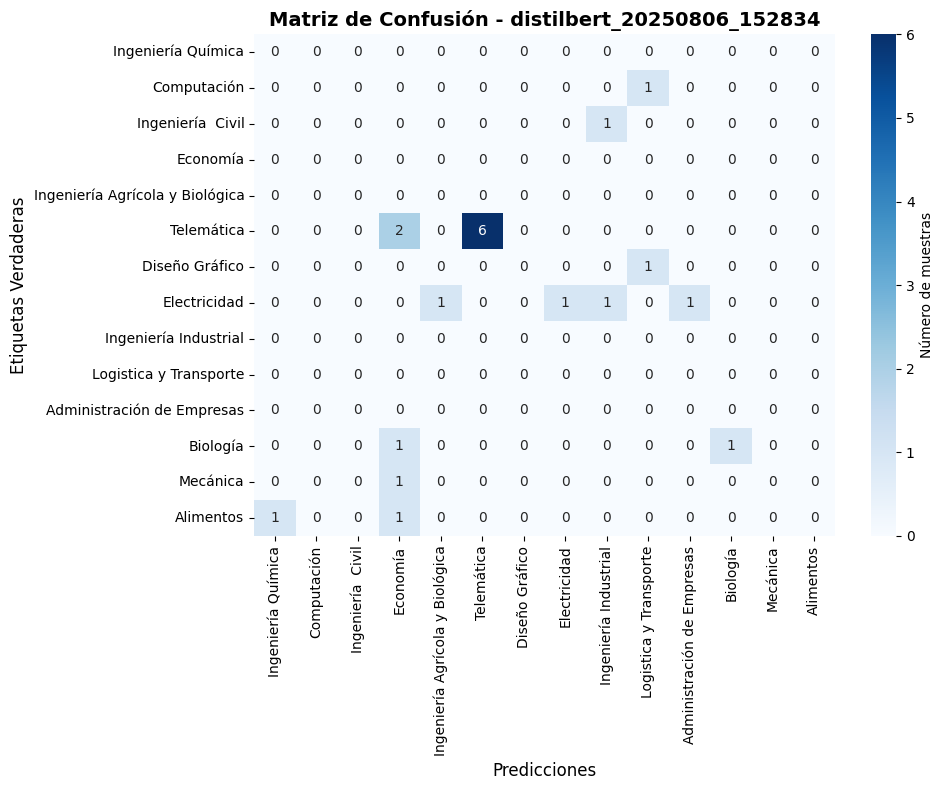


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: [np.str_('1'), np.str_('10'), np.str_('14'), np.str_('15'), np.str_('16'), np.str_('18'), np.str_('19'), np.str_('2'), np.str_('23'), np.str_('32'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('9')]
   📈 Total de predicciones: 20

📊 Matriz de Confusión (formato tabla):
Predicho   1  10  14  15  16  18  19  2  23  32  5  6  7  9
Verdadero                                                  
1          0   0   0   0   0   0   0  0   0   0  0  0  0  0
10         0   0   0   0   0   0   0  0   0   1  0  0  0  0
14         0   0   0   0   0   0   0  0   1   0  0  0  0  0
15         0   0   0   0   0   0   0  0   0   0  0  0  0  0
16         0   0   0   0   0   0   0  0   0   0  0  0  0  0
18         0   0   0   2   0   6   0  0   0   0  0  0  0  0
19         0   0   0   0   0   0   0  0   0   1  0  0  0  0
2          0   0   0   0   1   0   0  1   1   0  1  0  0  0
23         0   0 

In [ ]:
# Ejemplo 3: Comparar múltiples modelos
print("\\n" + "="*60)
print("EJEMPLO 3: Matriz de Confusión y Comparación de Modelos")

# Ejemplo de cómo usar la función:
results = generate_confusion_matrix(
    model_loader=loader,
    model_folder="bert_20250806_234119",
    # model_folder="Random_Forest_20250804_100503",
    dataset_path='./data/dataset_test.csv',
    save_plot=True,
    figsize=(10, 8)
)

# Acceder a los resultados
print("Accuracy:", results['accuracy'])
print("Matriz como DataFrame:")
print(results['confusion_matrix_df'])

print("✅ Función 'generate_confusion_matrix' creada exitosamente!")
print("\n📝 Características principales:")
print("   🔍 Detecta automáticamente el tipo de modelo")
print("   📊 Genera matriz de confusión visual con seaborn")
print("   💾 Opción para guardar el gráfico")
print("   📈 Calcula métricas básicas (accuracy, F1)")
print("   🏷️  Maneja automáticamente tipos mixtos de etiquetas")
print("   📋 Muestra estadísticas detalladas")

In [ ]:
def evaluate_all_models(model_loader, dataset_path, text_column='text',
                       label_column='label', save_plots=True,
                       output_dir='./imgs'):
    """
    Evalúa todos los modelos cargados en el model_loader y genera sus matrices de confusión

    Args:
        model_loader: Instancia del cargador de modelos
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        save_plots: Si guardar los gráficos como archivos (default: False)
        output_dir: Directorio donde guardar las matrices (default: './confusion_matrices')

    Returns:
        dict: Diccionario con resultados de todos los modelos
    """

    print(f"\n🚀 Evaluando TODOS los modelos cargados")
    print(f"   📁 Dataset: {dataset_path}")

    list_models = []
    folders = glob.glob("./models/traditional/*")
    for i in folders:
        list_models.append("traditional-" + i.split("\\")[-1])
    folders = glob.glob("./models/transformers/*")
    for i in folders:
        list_models.append("transformers-" + i.split("\\")[-1])
    
    print(f"   📊 Modelos disponibles: {list_models}")

    if len(list_models) == 0:
        print("❌ No hay modelos cargados. Carga algunos modelos primero.")
        return {}

    # Crear directorio de salida si se van a guardar plots
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
        print(f"   💾 Matrices se guardarán en: {output_dir}")

    all_results = {}
    summary_metrics = []

    print(f"\n" + "="*80)

    for type_and_model_name in list_models:
        model_type = type_and_model_name.split("-")[0]  # Extraer tipo de modelo
        model_name = type_and_model_name.split("-")[-1]  # Extraer solo el nombre del modelo
        print(f"\n🔍 Evaluando modelo: {model_name}")

        try:
            plot_filename = None
            if save_plots:
                plot_filename = f"{output_dir}/confusion_matrix_{model_name}.png"

            results = generate_confusion_matrix(
                model_loader=model_loader,
                model_folder=model_name,
                dataset_path=dataset_path,
                text_column=text_column,
                label_column=label_column,
                model_type=model_type,
                save_plot=save_plots,
                plot_filename=plot_filename,
                figsize=(8, 6)
            )

            all_results[model_name] = results

            # Guardar métricas para el resumen
            summary_metrics.append({
                'Modelo': model_name,
                'Tipo': model_type,
                'Accuracy': results['accuracy'],
                'F1-Score': results['f1_score'],
                'Num_Etiquetas': len(results['labels'])
            })

            print(f"✅ {model_name} evaluado exitosamente")

        except Exception as e:
            print(f"❌ Error evaluando {model_name}: {str(e)}")
            all_results[model_name] = {'error': str(e)}
        finally:
            print("-" * 50)

    # Crear resumen comparativo
    print(f"\n" + "="*80)
    print("📊 RESUMEN COMPARATIVO DE TODOS LOS MODELOS")
    print("="*80)

    if summary_metrics:
        summary_df = pd.DataFrame(summary_metrics)
        summary_df = summary_df.sort_values('Accuracy', ascending=False)

        print("\n🏆 Ranking por Accuracy:")
        print(summary_df.to_string(index=False, float_format='%.4f'))

        # Gráfico comparativo
        plt.figure(figsize=(12, 6))

        # Subplot 1: Accuracy
        plt.subplot(1, 2, 1)
        bars1 = plt.bar(summary_df['Modelo'], summary_df['Accuracy'],
                       color='skyblue', alpha=0.7)
        plt.title('Accuracy por Modelo', fontweight='bold')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=90)
        plt.ylim(0, 1)

        # Añadir valores en las barras
        for bar, acc in zip(bars1, summary_df['Accuracy']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')

        # Subplot 2: F1-Score
        plt.subplot(1, 2, 2)
        bars2 = plt.bar(summary_df['Modelo'], summary_df['F1-Score'],
                       color='lightcoral', alpha=0.7)
        plt.title('F1-Score por Modelo', fontweight='bold')
        plt.ylabel('F1-Score')
        plt.xticks(rotation=90)
        plt.ylim(0, 1)

        # Añadir valores en las barras
        for bar, f1 in zip(bars2, summary_df['F1-Score']):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{f1:.3f}', ha='center', va='bottom')

        plt.tight_layout()

        if save_plots:
            comparison_file = f"{output_dir}/models_comparison.png"
            plt.savefig(comparison_file, dpi=300, bbox_inches='tight')
            print(f"\n💾 Gráfico comparativo guardado: {comparison_file}")

        plt.show()

        # Encontrar el mejor modelo
        best_model = summary_df.iloc[0]
        print(f"\n🥇 MEJOR MODELO:")
        print(f"   🏆 Nombre: {best_model['Modelo']}")
        print(f"   🎯 Accuracy: {best_model['Accuracy']:.4f}")
        print(f"   📈 F1-Score: {best_model['F1-Score']:.4f}")
        print(f"   🔧 Tipo: {best_model['Tipo']}")

        all_results['summary'] = {
            'summary_df': summary_df,
            'best_model': best_model.to_dict(),
            'total_models_evaluated': len(summary_metrics)
        }

    print(f"\n✅ Evaluación completa de {len(all_results)} modelos terminada")

    return all_results


In [23]:
for model_name in loader.loaded_models:# loader no carga los modelos, sino es con su metodo
    print("="*60)
    print(f"🔍 Evaluando modelo: {model_name}")

🔍 Evaluando modelo: Random_Forest_20250804_100503
🔍 Evaluando modelo: distilbert_20250806_152834


✅ Funciones creadas exitosamente!

📝 Funciones disponibles:

🚀 Evaluando TODOS los modelos cargados
   📁 Dataset: ./data/dataset_test.csv
   📊 Modelos disponibles: ['traditional-LinearSVC_20250804_100249', 'traditional-Logistic_Regression_20250804_100551', 'traditional-Random_Forest_20250804_100503', 'traditional-XGBoost_20250804_101658', 'transformers-bert_20250806_234119', 'transformers-distilbert_20250806_152834']
   💾 Matrices se guardarán en: ./imgs


🔍 Evaluando modelo: LinearSVC_20250804_100249

🔍 Generando matriz de confusión para: LinearSVC_20250804_100249
   📁 Dataset: ./data/dataset_test.csv
   📊 Dataset cargado: 20 muestras
📥 Cargando modelo tradicional: LinearSVC_20250804_100249
   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.8622
🔍 Procesando 20 textos para predicción...

📈 Métricas del modelo:
   🎯 Accuracy: 0.5000
   📊 F1-Score: 0.5762
   💾 Matriz guardada como: ./imgs/confusion_matrix_LinearSVC_20250804_100249.png


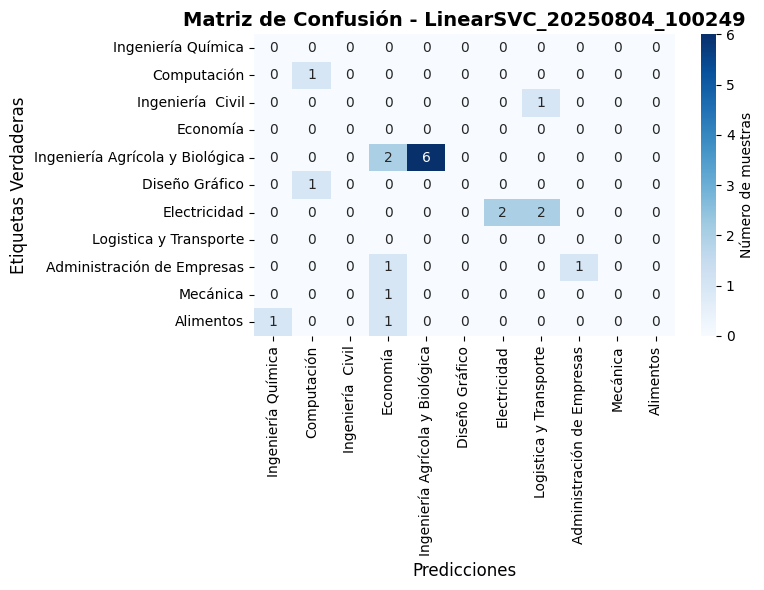


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (11, 11)
   🏷️  Etiquetas encontradas: [np.str_('1'), np.str_('10'), np.str_('14'), np.str_('15'), np.str_('18'), np.str_('19'), np.str_('2'), np.str_('23'), np.str_('6'), np.str_('7'), np.str_('9')]
   📈 Total de predicciones: 20

📊 Matriz de Confusión (formato tabla):
Predicho   1  10  14  15  18  19  2  23  6  7  9
Verdadero                                       
1          0   0   0   0   0   0  0   0  0  0  0
10         0   1   0   0   0   0  0   0  0  0  0
14         0   0   0   0   0   0  0   1  0  0  0
15         0   0   0   0   0   0  0   0  0  0  0
18         0   0   0   2   6   0  0   0  0  0  0
19         0   1   0   0   0   0  0   0  0  0  0
2          0   0   0   0   0   0  2   2  0  0  0
23         0   0   0   0   0   0  0   0  0  0  0
6          0   0   0   1   0   0  0   0  1  0  0
7          0   0   0   1   0   0  0   0  0  0  0
9          1   0   0   1   0   0  0   0  0  0  0
✅ LinearSVC_20250804_100

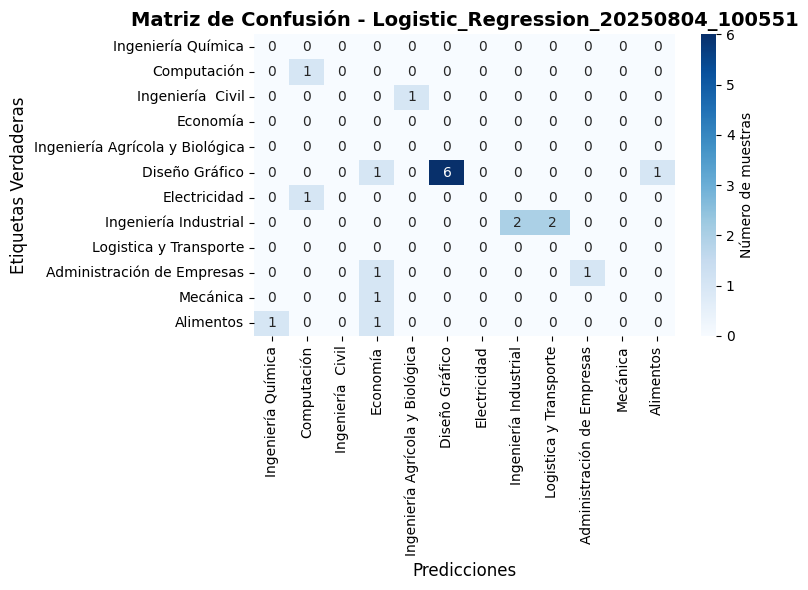


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (12, 12)
   🏷️  Etiquetas encontradas: [np.str_('1'), np.str_('10'), np.str_('14'), np.str_('15'), np.str_('16'), np.str_('18'), np.str_('19'), np.str_('2'), np.str_('23'), np.str_('6'), np.str_('7'), np.str_('9')]
   📈 Total de predicciones: 20

📊 Matriz de Confusión (formato tabla):
Predicho   1  10  14  15  16  18  19  2  23  6  7  9
Verdadero                                           
1          0   0   0   0   0   0   0  0   0  0  0  0
10         0   1   0   0   0   0   0  0   0  0  0  0
14         0   0   0   0   1   0   0  0   0  0  0  0
15         0   0   0   0   0   0   0  0   0  0  0  0
16         0   0   0   0   0   0   0  0   0  0  0  0
18         0   0   0   1   0   6   0  0   0  0  0  1
19         0   1   0   0   0   0   0  0   0  0  0  0
2          0   0   0   0   0   0   0  2   2  0  0  0
23         0   0   0   0   0   0   0  0   0  0  0  0
6          0   0   0   1   0   0   0  0   0  1  0  0
7         

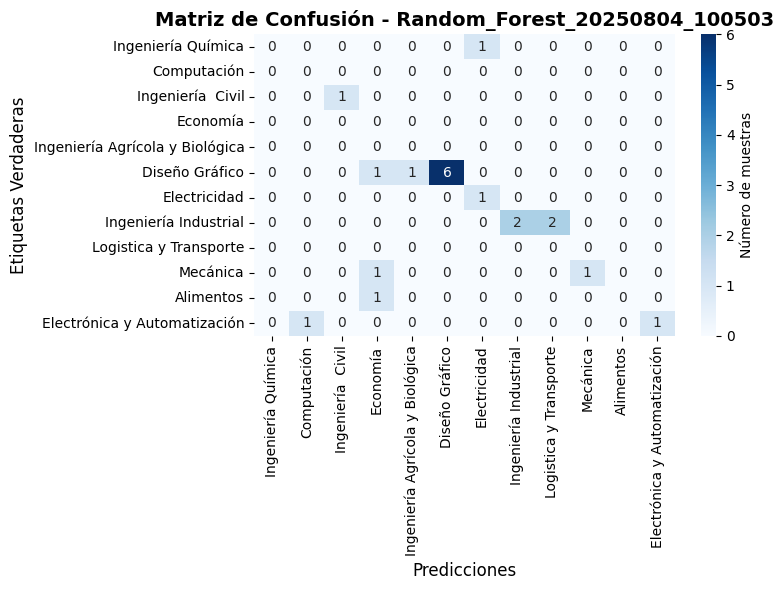


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (12, 12)
   🏷️  Etiquetas encontradas: [np.str_('10'), np.str_('11'), np.str_('14'), np.str_('15'), np.str_('16'), np.str_('18'), np.str_('19'), np.str_('2'), np.str_('23'), np.str_('6'), np.str_('7'), np.str_('9')]
   📈 Total de predicciones: 20

📊 Matriz de Confusión (formato tabla):
Predicho   10  11  14  15  16  18  19  2  23  6  7  9
Verdadero                                            
10          0   0   0   0   0   0   1  0   0  0  0  0
11          0   0   0   0   0   0   0  0   0  0  0  0
14          0   0   1   0   0   0   0  0   0  0  0  0
15          0   0   0   0   0   0   0  0   0  0  0  0
16          0   0   0   0   0   0   0  0   0  0  0  0
18          0   0   0   1   1   6   0  0   0  0  0  0
19          0   0   0   0   0   0   1  0   0  0  0  0
2           0   0   0   0   0   0   0  2   2  0  0  0
23          0   0   0   0   0   0   0  0   0  0  0  0
6           0   0   0   1   0   0   0  0   0  1  0 

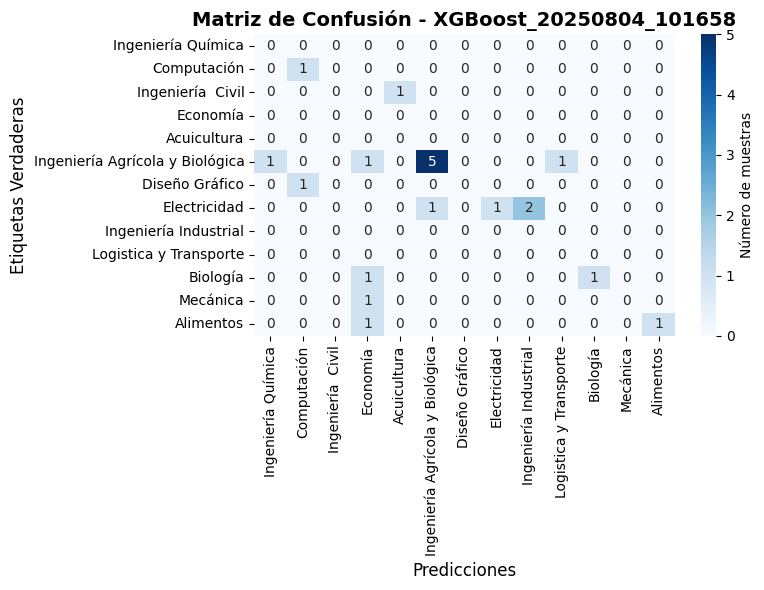


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (13, 13)
   🏷️  Etiquetas encontradas: [np.str_('0'), np.str_('10'), np.str_('14'), np.str_('15'), np.str_('16'), np.str_('18'), np.str_('19'), np.str_('2'), np.str_('23'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('9')]
   📈 Total de predicciones: 20

📊 Matriz de Confusión (formato tabla):
Predicho   0  10  14  15  16  18  19  2  23  5  6  7  9
Verdadero                                              
0          0   0   0   0   0   0   0  0   0  0  0  0  0
10         0   1   0   0   0   0   0  0   0  0  0  0  0
14         0   0   0   0   1   0   0  0   0  0  0  0  0
15         0   0   0   0   0   0   0  0   0  0  0  0  0
16         0   0   0   0   0   0   0  0   0  0  0  0  0
18         1   0   0   1   0   5   0  0   0  1  0  0  0
19         0   1   0   0   0   0   0  0   0  0  0  0  0
2          0   0   0   0   0   1   0  1   2  0  0  0  0
23         0   0   0   0   0   0   0  0   0  0  0  0  0
5          0   0

c:\Users\saraujo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


   ✅ Modelo cargado exitosamente
   📊 Test Accuracy: 0.9026
🔍 Procesando 20 textos para predicción...

📈 Métricas del modelo:
   🎯 Accuracy: 0.4500
   📊 F1-Score: 0.5429
   💾 Matriz guardada como: ./imgs/confusion_matrix_bert_20250806_234119.png


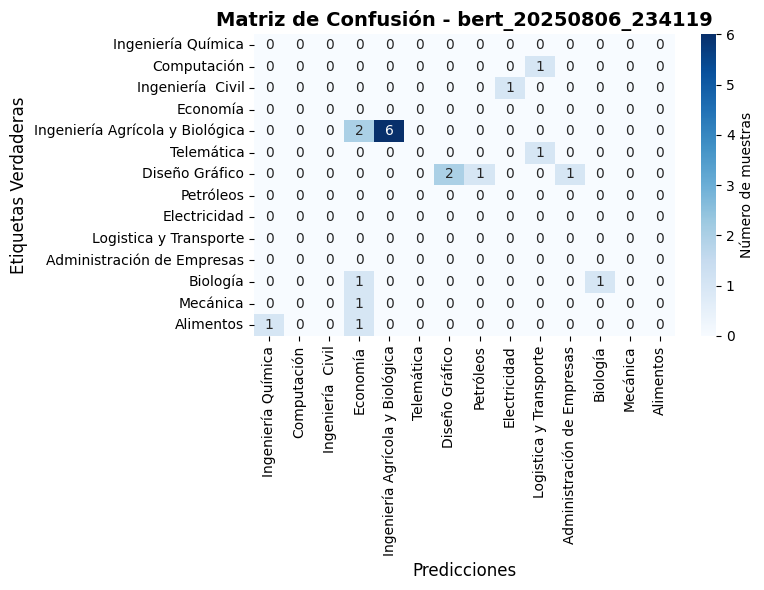


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: [np.str_('1'), np.str_('10'), np.str_('14'), np.str_('15'), np.str_('18'), np.str_('19'), np.str_('2'), np.str_('23'), np.str_('27'), np.str_('32'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('9')]
   📈 Total de predicciones: 20

📊 Matriz de Confusión (formato tabla):
Predicho   1  10  14  15  18  19  2  23  27  32  5  6  7  9
Verdadero                                                  
1          0   0   0   0   0   0  0   0   0   0  0  0  0  0
10         0   0   0   0   0   0  0   0   0   1  0  0  0  0
14         0   0   0   0   0   0  0   0   1   0  0  0  0  0
15         0   0   0   0   0   0  0   0   0   0  0  0  0  0
18         0   0   0   2   6   0  0   0   0   0  0  0  0  0
19         0   0   0   0   0   0  0   0   0   1  0  0  0  0
2          0   0   0   0   0   0  2   1   0   0  1  0  0  0
23         0   0   0   0   0   0  0   0   0   0  0  0  0  0
27         0   0 

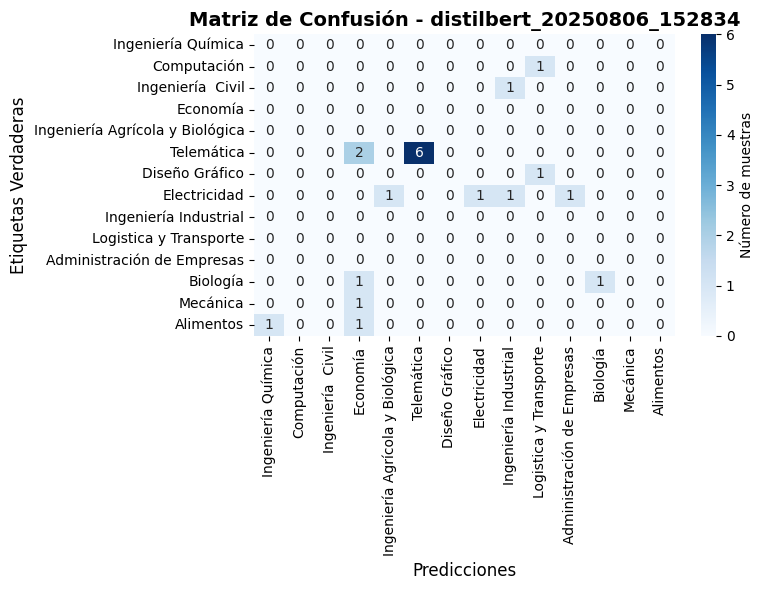


📋 Estadísticas de la Matriz de Confusión:
   📊 Forma de la matriz: (14, 14)
   🏷️  Etiquetas encontradas: [np.str_('1'), np.str_('10'), np.str_('14'), np.str_('15'), np.str_('16'), np.str_('18'), np.str_('19'), np.str_('2'), np.str_('23'), np.str_('32'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('9')]
   📈 Total de predicciones: 20

📊 Matriz de Confusión (formato tabla):
Predicho   1  10  14  15  16  18  19  2  23  32  5  6  7  9
Verdadero                                                  
1          0   0   0   0   0   0   0  0   0   0  0  0  0  0
10         0   0   0   0   0   0   0  0   0   1  0  0  0  0
14         0   0   0   0   0   0   0  0   1   0  0  0  0  0
15         0   0   0   0   0   0   0  0   0   0  0  0  0  0
16         0   0   0   0   0   0   0  0   0   0  0  0  0  0
18         0   0   0   2   0   6   0  0   0   0  0  0  0  0
19         0   0   0   0   0   0   0  0   0   1  0  0  0  0
2          0   0   0   0   1   0   0  1   1   0  1  0  0  0
23         0   0 

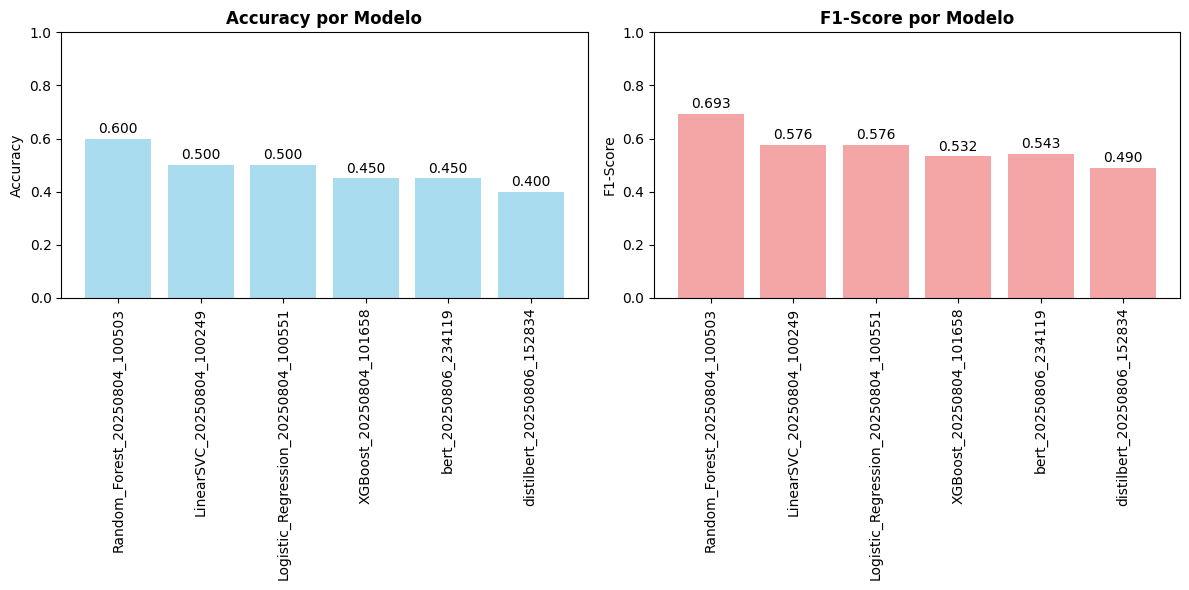


🥇 MEJOR MODELO:
   🏆 Nombre: Random_Forest_20250804_100503
   🎯 Accuracy: 0.6000
   📈 F1-Score: 0.6929
   🔧 Tipo: traditional

✅ Evaluación completa de 7 modelos terminada


{'LinearSVC_20250804_100249': {'confusion_matrix': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]),
  'labels': [np.str_('1'),
   np.str_('10'),
   np.str_('14'),
   np.str_('15'),
   np.str_('18'),
   np.str_('19'),
   np.str_('2'),
   np.str_('23'),
   np.str_('6'),
   np.str_('7'),
   np.str_('9')],
  'accuracy': 0.5,
  'f1_score': 0.5761904761904761,
  'predictions': ['18',
   '10',
   '15',
   '23',
   '15',
   '1',
   '18',
   '2',
   '23',
   '10',
   '23',
   '6',
   '15',
   '18',
   '18',
   '2',
   '18',
   '15',
   '18',
   '15'],
  'true_labels':

In [24]:
print("✅ Funciones creadas exitosamente!")
print("\n📝 Funciones disponibles:")
evaluate_all_models(model_loader=loader, dataset_path='./data/dataset_test.csv')

In [100]:
def evaluate_top_k_accuracy(model_loader, model_folder, dataset_path, k=3,
                           text_column='text', label_column='label',
                           model_type='auto', verbose=True):
    """
    Evalúa si la etiqueta verdadera está entre las top-k predicciones con mayor probabilidad

    Args:
        model_loader: Instancia del cargador de modelos
        model_folder: Nombre de la carpeta del modelo
        dataset_path: Ruta al archivo del dataset (CSV o JSON)
        k: Número de predicciones top a considerar (default: 3)
        text_column: Nombre de la columna de texto (default: 'text')
        label_column: Nombre de la columna de etiquetas (default: 'label')
        model_type: Tipo de modelo ('auto', 'traditional', 'transformer')
        verbose: Si mostrar información detallada (default: True)

    Returns:
        dict: Diccionario con métricas de top-k accuracy
    """

    if verbose:
        print(f"\n🎯 Evaluando Top-{k} Accuracy para: {model_folder}")
        print(f"   📁 Dataset: {dataset_path}")

    # Cargar dataset
    if dataset_path.endswith('.csv'):
        df = read_csv_dataset(dataset_path)
    elif dataset_path.endswith('.json'):
        df = pd.read_json(dataset_path)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o JSON.")

    texts = df[text_column].astype(str).tolist()
    
    if verbose:
        print(f"   📊 Dataset cargado: {len(texts)} muestras")

    # Detectar tipo de modelo si es automático
    if model_type == 'auto':
        if model_folder in model_loader.loaded_models:
            model_type = model_loader.loaded_models[model_folder]['type']
        else:
            if os.path.exists(f"{model_loader.models_dir}/traditional/{model_folder}"):
                model_type = 'traditional'
            elif os.path.exists(f"{model_loader.models_dir}/transformers/{model_folder}"):
                model_type = 'transformer'
            else:
                raise ValueError(f"No se pudo detectar el tipo de modelo para: {model_folder}")

    # Hacer predicciones
    print("Prediciendo etiquetas...")
    if model_type == 'traditional':
        predictions, probabilities = model_loader.predict_traditional(model_folder, texts)
    else:
        predictions, probabilities = model_loader.predict_transformer(model_folder, texts)

    # print("predictions", predictions)
    # print("probabilities", probabilities)
    predictions = [str(pred) for pred in predictions]
    label_encoder = model_loader.loaded_models[model_folder]['label_encoder']
    true_labels = df[label_column].apply(lambda x: label_encoder.transform([x])[0] if isinstance(x, str) else 0) # lleva el texto a su etiqueta numérica
    

    # Convertir etiquetas a string para consistencia
    true_labels = [str(label) for label in true_labels]

    # Calcular Top-1 accuracy (accuracy normal)
    top1_correct = sum(1 for true, pred in zip(true_labels, predictions) if true == pred)
    top1_accuracy = top1_correct / len(true_labels)

    # Calcular Top-k accuracy
    topk_correct = 0
    detailed_results = []

    classes = label_encoder.classes_ 

    print(f"   🏷️ Clases a detectar: {len(classes)} clases únicas")
    # print("clases", classes)
    # print(len(classes))
    # print("true_labels", true_labels)
    # print(len(true_labels))

    # print("probabilities", probabilities)
    # print(len(probabilities))


    for i, (true_label, prob_array) in enumerate(zip(true_labels, probabilities)):
        # true label a etiqueta 
        true_label = classes[int(true_label)]
        top_k_indices = np.argsort(prob_array)[-k:][::-1]  # Índices ordenados descendente
        # print("top_k_indices", top_k_indices)
        top_k_classes = [classes[idx] for idx in top_k_indices]
        top_k_probs = [prob_array[idx] for idx in top_k_indices]
        # print("true_label", true_label)
        # print("top_k_classes", top_k_classes)
        # print("top_k_probs", top_k_probs)

        # Verificar si la etiqueta verdadera está en el top-k
        is_in_topk = true_label in top_k_classes
        if is_in_topk:
            topk_correct += 1

        detailed_results.append({
            'sample_idx': i,
            'true_label': true_label,
            'top_prediction': predictions[i],
            f'top_{k}_classes': top_k_classes,
            f'top_{k}_probabilities': top_k_probs,
            f'in_top_{k}': is_in_topk
        })

    topk_accuracy = topk_correct / len(true_labels)

    if verbose:
        print(f"\n📈 Resultados Top-{k} Accuracy:")
        print(f"   🎯 Top-1 Accuracy: {top1_accuracy:.4f} ({top1_correct}/{len(true_labels)})")
        print(f"   🏆 Top-{k} Accuracy: {topk_accuracy:.4f} ({topk_correct}/{len(true_labels)})")
        print(f"   📊 Mejora: +{(topk_accuracy - top1_accuracy):.4f} ({((topk_accuracy - top1_accuracy) / top1_accuracy * 100):.1f}%)")

        # Mostrar algunos ejemplos donde top-k ayudó
        helped_cases = [r for r in detailed_results if r[f'in_top_{k}'] and r['true_label'] != r['top_prediction']]
        if helped_cases and len(helped_cases) > 0:
            print(f"\n💡 Ejemplos donde Top-{k} ayudó (primeros 3):")
            for case in helped_cases[:3]:
                print(f"   📝 Muestra {case['sample_idx']}: Verdadero='{case['true_label']}', "
                      f"Predicho='{case['top_prediction']}', Top-{k}={case[f'top_{k}_classes']}")

    return {
        'top1_accuracy': top1_accuracy,
        f'top{k}_accuracy': topk_accuracy,
        'improvement': topk_accuracy - top1_accuracy,
        'improvement_percentage': ((topk_accuracy - top1_accuracy) / top1_accuracy * 100) if top1_accuracy > 0 else 0,
        'total_samples': len(true_labels),
        'top1_correct': top1_correct,
        f'top{k}_correct': topk_correct,
        'detailed_results': detailed_results,
        'k': k
    }

In [101]:
print("   🚀  - Evalúa todos los modelos cargados")
evaluate_top_k_accuracy(
    model_loader=loader,
    # model_folder="Random_Forest_20250804_100503",  #  0.5385 (14/26)  -  0.8077 (21/26) # 0.7s
    model_folder="bert_20250806_234119",  #  0.5385 (14/26)  -  0.8077 (21/26) # 0.7s
    
    dataset_path='./data/dataset_test.csv')

   🚀  - Evalúa todos los modelos cargados

🎯 Evaluando Top-3 Accuracy para: bert_20250806_234119
   📁 Dataset: ./data/dataset_test.csv
   📊 Dataset cargado: 20 muestras
Prediciendo etiquetas...
🔍 Cargando modelo transformer: bert_20250806_234119
🔍 Procesando 20 textos para predicción...
   🏷️ Clases a detectar: 34 clases únicas

📈 Resultados Top-3 Accuracy:
   🎯 Top-1 Accuracy: 0.4500 (9/20)
   🏆 Top-3 Accuracy: 0.8000 (16/20)
   📊 Mejora: +0.3500 (77.8%)

💡 Ejemplos donde Top-3 ayudó (primeros 3):
   📝 Muestra 0: Verdadero='Ingeniería Química', Predicho='18', Top-3=['Ingeniería Química', 'Materiales', 'Diseño de Productos']
   📝 Muestra 3: Verdadero='Ingeniería  Civil', Predicho='27', Top-3=['Petróleos', 'Ingeniería  Civil', 'Mecánica']
   📝 Muestra 5: Verdadero='Economía', Predicho='1', Top-3=['Administración de Empresas', 'Economía', 'Ingeniería Industrial']


{'top1_accuracy': 0.45,
 'top3_accuracy': 0.8,
 'improvement': 0.35000000000000003,
 'improvement_percentage': 77.77777777777779,
 'total_samples': 20,
 'top1_correct': 9,
 'top3_correct': 16,
 'detailed_results': [{'sample_idx': 0,
   'true_label': 'Ingeniería Química',
   'top_prediction': '18',
   'top_3_classes': ['Ingeniería Química',
    'Materiales',
    'Diseño de Productos'],
   'top_3_probabilities': [0.9595232605934143,
    0.02972988784313202,
    0.0011469448218122125],
   'in_top_3': True},
  {'sample_idx': 1,
   'true_label': 'Logistica y Transporte',
   'top_prediction': '32',
   'top_3_classes': ['Telemática', 'Telecomunicaciones', 'Electricidad'],
   'top_3_probabilities': [0.7771722078323364,
    0.11531172692775726,
    0.041311830282211304],
   'in_top_3': False},
  {'sample_idx': 2,
   'true_label': 'Diseño Gráfico',
   'top_prediction': '15',
   'top_3_classes': ['Ingeniería Agrícola y Biológica',
    'Producción para Medios de Comunicación',
    'Turismo'],
   '

In [ ]:
print("\n💡 Ejemplos de uso:")
print("   ")
print("   # Evaluar top-3 accuracy de un modelo específico")
print("   top3_results = evaluate_top_k_accuracy(loader, 'SVM', './data/dataset_test.csv', k=3)")


💡 Ejemplos de uso:
   
   # Evaluar top-3 accuracy de un modelo específico
   top3_results = evaluate_top_k_accuracy(loader, 'SVM', './data/dataset_test.csv', k=3)


# load_models

In [27]:
def load_traditional_model(model_dir):
    """Carga modelo tradicional guardado"""
    model_path = f"{model_dir}/model.pkl"
    vectorizer_path = f"{model_dir}/vectorizer.pkl"
    metadata_path = f"{model_dir}/metadata.json"
    label_path = f"{model_dir}/label_encoder.pkl"

    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
    label_encoder = joblib.load(label_path)

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    return model, vectorizer, metadata, label_encoder

In [28]:
def load_transformer_model(model_dir):
    """Carga modelo transformer guardado"""
    metadata_path = f"{model_dir}/metadata.json"
    label_path = f"{model_dir}/label_encoder.pkl"

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    tokenizer = AutoTokenizer.from_pretrained(model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    label_encoder = joblib.load(label_path)

    return model, tokenizer, metadata, label_encoder

### Primeros pasos

In [29]:
models_dir = "./models/*"
list_dir = glob.glob(models_dir)
models_upload = {}


In [30]:
folders = glob.glob("./models/traditional/*")
for i in folders:
    print(i.split("\\")[-1])
    models_upload[i.split("\\")[-1]] = load_traditional_model(i.replace("\\", "/"))

LinearSVC_20250804_100249
Logistic_Regression_20250804_100551
Random_Forest_20250804_100503
XGBoost_20250804_101658


In [31]:
folders = glob.glob("./models/transformers/*")
for i in folders:
    print(i.split("\\")[-1])
    models_upload[i.split("\\")[-1]] = load_transformer_model(i.replace("\\", "/"))

bert_20250806_234119
distilbert_20250806_152834


c:\Users\saraujo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\saraujo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [32]:
models_upload['Random_Forest_20250804_100503']

(RandomForestClassifier(n_jobs=-1, random_state=42),
 TfidfVectorizer(max_features=100000,
                 stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                             'del', 'se', 'las', 'por', 'un', 'para', 'con',
                             'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                             'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                             'porque', ...]),
 {'model_name': 'Random_Forest',
  'timestamp': '20250804_100503',
  'val_accuracy': 0.9448702830188679,
  'test_accuracy': 0.9414209905660378,
  'val_f1': 0.9448277963447962,
  'test_f1': 0.9412712565182166,
  'gpu_used': False,
  'model_path': './models/traditional/Random_Forest_20250804_100503/model.pkl',
  'vectorizer_path': './models/traditional/Random_Forest_20250804_100503/vectorizer.pkl'},
 LabelEncoder())

In [33]:
model = models_upload['Random_Forest_20250804_100503'][0]
vectorizer = models_upload['Random_Forest_20250804_100503'][1]
label_encoder = models_upload['Random_Forest_20250804_100503'][3]

In [34]:
list_text = [
    "diseño de un proceso escala piloto para extender la vida útil del limón sutil",
    # Alimentos el 1
    "diseño de estrategia para operativizar corredores turísticos seguros en guayaquil",
    # Turismo el 1
    "rediseño de la red inalámbrica de la facultad de ingenieria en electricidad y computación",
    # Telemática el 1
    "diseño de un circuito de bombeo capilar para enfriamiento pasivo de baterías de litio para autos eléctricos",
    # Mecánica el 1
    "valoración económica de la protección contra los riesgos de inundaciones en durán",
    # Economía el 1
    "diseño y simulación de un sistema de control optimizado para un condensador adiabático",
    # Mecánica el 1
    "análisis energético exergético y económico de los sistema de refrigeración de aire forzado convencional y un sistema de refrigeración de compresores en paralelo rack",
    # Mecánica el 1
    "predicción de superficies de contacto en tareas robóticas repetitivas",
    # Mecatrónica el 1
    "modelo multivariante para predecir abundancia y diversidad de aves según variables climáticas en el campus de la espol",
    # Matemática el 1
    "estudio y diseño de pre factibilidad para el nuevo puente sobre el río salinas ubicado antes del ingreso de la ciudad de guaranda provincia del bolivar",
    # Ingeniería  Civil el 1
    "prediseño ingenieril para control de inundaciones en el sector suroeste de guayaquil",
    # Ingeniería  Civil el 1
    "diseño de un manual de procesos para gestión de contingencias en una empresa de comercialización de equipos industriales",
    # Auditoría y Control de Gestión el 1
    "plan de marketing para implementar un nuevo programa de pregrado en administración de empresas autofinanciado para una institución pública de educación superior del ecuador",
    # Administración de Empresas el 1
    "diseño de estrategias de promoción para la ruta del sombrero de paja toquilla",
    # Turismo el 1
    "voces valientes un libro didáctico para proteger y educar a niños sobre el abuso sexual",
    # Diseño Gráfico el 1
    "diseño y modelamiento de una central térmica para el aumento de la eficiencia energética con aplicación en hardware in the loop",
    # Electricidad el 1
    "determinación de las condiciones de un inóculo anaeróbico diseñado para biodegradar películas poliméricas y no poliméricas",
    # Biología =============== el 4
    "estudio y diseño de prefactibilidad para el nuevo puente sobre el río salinas ubicado antes del ingreso de la ciudad de guaranda",
    # Ingeniería  Civil el 1
    "prediseño estructural de la superestructura y subestructura para un shopping comercial de plantas en la ciudad de tabacundo provincia de pichincha",
    # Ingeniería  Civil el 1
    "análisis de valores antropométricos de una población laboral operativa e incidencia de sus hábitos alimenticios",
    # Nutrición el 1
    "diseño de sistema de control y gestión de inventario en una empresa distribuidora de productos farmacéuticos",
    # Ingeniería Industrial el 1
    "diseño de un elevador hidráulico para contenedores de y pies de longitud",
    # Mecatrónica el 1
    "diseño de sistema de climatización para edificio comercial",
    # Mecánica el 1
    "estimación de reservas del campo vinita",
    #Petróleos  el 1
    # 4 - 4
    "El diseño de personajes como embajadores de mensaje y la creación de escenografías atractivas en los videojuegos educativos, son esenciales para garantizar su efectividad de uso. Este estudio se enfoca en la educación musical infantil apoyada en la implementación de una serie de videojuegos llamada MIDI-Musical. Metodologías cualitativas como Design Thinking, consideradas como aspectos claves en investigación aplicada al diseño, respaldan la creación de sus personajes, arquetipos y escenarios, garantizando producciones bien informadas. Con base en los resultados, se busca fortalecer la conexión entre aprendizaje y diversión dentro del contexto educativo musical, potenciando nuevas investigaciones relacionadas con videojuegos serios infantiles.",
    # 13 - 12
    "The increasing demand for natural fibers, driven by their advantageous attributes such as low density, sustainability, and high specific strength, has promoted the adoption of sustainable alternatives in composites. Although alkali treatments are known to improve fiber properties, they entail challenges regarding NaOH consumption and environmental impact, making it necessary to explore cleaner production strategies. This study evaluated the effects of implementing a circular economy approach through the recirculation of an NaOH solution on the treatment of abaca fibers. The fiber properties were assessed using thermogravimetric analysis (TGA), scanning electron microscopy (SEM), and tensile strength testing, along with an evaluation of the carbon footprint through a life cycle assessment. New life cycle inventories were developed to reflect the NaOH recirculation process. Comparative analyses were conducted using polypropylene fibers. The findings indicate that the recirculation of the NaOH solution remains effective for up to eight cycles, producing consistent TGA, SEM, and tensile strength results while achieving a 25 % reduction in the carbon footprint compared to conventional treatment. Additionally, this study highlights the environmental advantages of abaca over synthetic fibers, with increased tensile strength (8–46 %) and carbon footprint reduction (55–86 %) compared to polypropylene fibers. These results highlight the potential of abaca fibers to contribute to the circular economy, enhance resource efficiency, and mitigate climate change.",
    # 14 - 8,11,12
    "Motivations for traveling to World Heritage natural destinations shape important theories for academic research. This study aims to analyze the influence of motivational factors on tourist satisfaction in the Galápagos Islands. The quantitative study was conducted in situ; a total of 407 valid questionnaires were collected at Mann Beach on San Cristobal Island in the Galápagos Islands, Ecuador. Through structural equation modeling, the analysis identified key motivations contributing to satisfaction, with novelty-seeking and social interaction emerging as key determinants. In contrast, motivations such as learning and authentic coastal experiences were found to have an insignificant impact on tourists’ overall perceptions. The findings also confirmed a strong positive relationship between satisfaction and loyalty, demonstrating that satisfied tourists are more likely to return and spread positive word-of-mouth about the destination. These results highlight the importance of designing tourism experiences that align with visitors’ expectations for social interaction and novelty, thereby enhancing the sustainability and reputation of the Galápagos Islands as a unique destination.",
    # 14 -14
    "This study aims to investigate the demand for ecotourism in marine protected areas by (a) identifying motivations specific to marine protected areas, (b) establishing the relationship between social and demographic variables and motivations, and (c) determining the relationship between social and demographic characteristics, satisfaction, and loyalty variables. The study was conducted in Santa Elena Province at the reserve called “Puntilla”, which is a coastal marine and fauna production reserve in Ecuador, a country renowned for its biodiversity. The sample comprised 369 on-site surveys. Factor analysis and stepwise multiple regression methods were used for data analysis. The results revealed associations between social and demographic variables and tourist motivations. Specifically, lower-income tourists were most motivated by “escape and ego-defensive function motivation” and reported higher satisfaction levels. Conversely, tourists who visited the destination less frequently displayed stronger motivations related to nature and showed high satisfaction. Furthermore, visitors who spent less at the destination demonstrated a greater intention to return and recommend the area to others. These findings hold significant implications for protected areas management and contribute to the scientific literature on ecotourism in similar protected areas.",
]

### Preproceso
1. identificar idioma
2. traduccion de ser necesario
3. lematizacion


In [35]:
model_ckpt = "papluca/xlm-roberta-base-language-detection"
tokenizer_detected = AutoTokenizer.from_pretrained(model_ckpt)
model_detected = AutoModelForSequenceClassification.from_pretrained(model_ckpt)

In [36]:
result_list = []
inputs = tokenizer_detected(list_text, padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    logits = model_detected(**inputs).logits

preds = torch.softmax(logits, dim=-1)
id2lang = model_detected.config.id2label
vals, idxs = torch.max(preds, dim=1)
result_list.extend([(id2lang[k.item()], v.item()) for k, v in zip(idxs, vals)])

result_list

[('es', 0.9870215058326721),
 ('pt', 0.8166074156761169),
 ('es', 0.9842292070388794),
 ('es', 0.8747622966766357),
 ('es', 0.9791497588157654),
 ('es', 0.987558901309967),
 ('es', 0.9901795387268066),
 ('es', 0.9829808473587036),
 ('es', 0.984525740146637),
 ('es', 0.9859402179718018),
 ('es', 0.9905493855476379),
 ('es', 0.9675434827804565),
 ('es', 0.8855929970741272),
 ('es', 0.9850613474845886),
 ('es', 0.9868011474609375),
 ('es', 0.993104875087738),
 ('es', 0.9832956194877625),
 ('es', 0.9869014620780945),
 ('es', 0.9871900677680969),
 ('pt', 0.7199559211730957),
 ('es', 0.9878629446029663),
 ('es', 0.9724005460739136),
 ('es', 0.7569050192832947),
 ('es', 0.8785988688468933),
 ('es', 0.9843220114707947),
 ('en', 0.9912347793579102),
 ('en', 0.984295129776001),
 ('en', 0.9860057830810547)]

In [37]:
# model_name = "Helsinki-NLP/opus-mt-es-en"
model_name = "Helsinki-NLP/opus-mt-en-es"
# model_name = "Helsinki-NLP/opus-mt-tc-big-en-es"

tokenizer_tradu = MarianTokenizer.from_pretrained(model_name)
model_tradu = MarianMTModel.from_pretrained(model_name)

c:\Users\saraujo\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\marian\tokenization_marian.py:177: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [38]:
def get_translation(text):
  translated = model_tradu.generate(**tokenizer_tradu(text, return_tensors="pt", padding=True))
  return tokenizer_tradu.decode(translated[0], skip_special_tokens=True)

In [39]:
list_new_text = []

for i in range(len(result_list)):
    lang = result_list[i][0]
    if lang == "en":
        print(f"Translating text {i} from English to Spanish")
        resp = get_translation(list_text[i])
        print(resp)
        list_new_text.append(resp)
    else:
        list_new_text.append(list_text[i])

Translating text 25 from English to Spanish
La creciente demanda de fibras naturales, impulsada por sus atributos ventajosos como baja densidad, sostenibilidad y alta resistencia específica, ha promovido la adopción de alternativas sostenibles en compuestos. Aunque se sabe que los tratamientos alcalinos mejoran las propiedades de la fibra, conllevan desafíos en cuanto al consumo de NaOH y el impacto ambiental, lo que hace necesario explorar estrategias de producción más limpia. Este estudio evaluó los efectos de implementar un enfoque de economía circular mediante la recirculación de una solución NaOH en el tratamiento de fibras de abaca. Las propiedades de la fibra se evaluaron mediante análisis termogravimétrico (TGA), microscopía electrónica de barrido (SEM) y pruebas de resistencia a la tracción, junto con una evaluación de la huella de carbono mediante una evaluación del ciclo de vida. Se desarrollaron nuevos inventarios del ciclo de vida para reflejar el proceso de recirculación 

lematizacion de la lista

In [40]:
new_list_lema = []

if len(list_new_text) == 0:
    list_new_text = list_text

for text in list_new_text:
    new_list_lema.append(crear_corpus(text))

### Prueba

In [41]:
new_list_lema

['diseño proceso escala piloto extender vida útil limón sutil',
 'diseño estrategia operativizar corredor turístico seguro guayaquil',
 'rediseño red inalámbrico facultad ingenieria electricidad computación',
 'diseño circuito bombeo capilar enfriamiento pasivo batería litio auto eléctrico',
 'valoración económico protección riesgo inundación durán',
 'diseño simulación sistema control optimizado condensador adiabático',
 'análisis energético exergético económico sistema refrigeración aire forzado convencional sistema refrigeración compresor paralelo rack',
 'predicción superficie contacto tarea robótica repetitiva',
 'modelo multivariante predecir abundancia diversidad ave según variable climático campus espol',
 'estudio diseño pre factibilidad nuevo puente río salinas ubicado ingreso ciudad guaranda provincia bolivar',
 'prediseño ingenieril control inundación sector suroeste guayaquil',
 'diseño manual proceso gestión contingencia empresa comercialización equipo industrial',
 'plan

In [42]:
models_upload.keys()

dict_keys(['LinearSVC_20250804_100249', 'Logistic_Regression_20250804_100551', 'Random_Forest_20250804_100503', 'XGBoost_20250804_101658', 'bert_20250806_234119', 'distilbert_20250806_152834'])

##### Traditional

In [62]:
key_model = "Random_Forest_20250804_100503"
list_text = new_list_lema
model = models_upload[key_model][0]
vectorizer = models_upload[key_model][1]
label_encoder = models_upload[key_model][3]

In [63]:
# Vectorizar textos
X_vec = vectorizer.transform(list_text)

# Predicciones
predictions = model.predict(X_vec)
probabilities = None

# Obtener probabilidades si el modelo las soporta
if hasattr(model, 'predict_proba'):
    probabilities = model.predict_proba(X_vec)

In [64]:
probabilities

array([[0.        , 0.        , 0.4       , 0.        , 0.01      ,
        0.        , 0.        , 0.01      , 0.        , 0.        ,
        0.01      , 0.02      , 0.        , 0.        , 0.01      ,
        0.        , 0.04      , 0.        , 0.39      , 0.        ,
        0.        , 0.01      , 0.        , 0.03      , 0.03      ,
        0.        , 0.        , 0.        , 0.02      , 0.        ,
        0.        , 0.        , 0.        , 0.02      ],
       [0.        , 0.00166667, 0.        , 0.        , 0.01333333,
        0.        , 0.        , 0.055     , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01      ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01      , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.91      ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
  

In [65]:
for i, (text, pred) in enumerate(zip(list_text, predictions)):
    prob_str = ""
    if probabilities is not None:
        max_prob = np.max(probabilities[i])
        prob_str = f" (confianza: {max_prob:.3f})"

    print(f"   {i+1}. Texto: '{text[:50]}...'")
    print(f"      Predicción: {pred}{prob_str} - Carrera: {label_encoder.classes_[pred]}")

   1. Texto: 'diseño proceso escala piloto extender vida útil li...'
      Predicción: 2 (confianza: 0.400) - Carrera: Alimentos
   2. Texto: 'diseño estrategia operativizar corredor turístico ...'
      Predicción: 33 (confianza: 0.910) - Carrera: Turismo
   3. Texto: 'rediseño red inalámbrico facultad ingenieria elect...'
      Predicción: 32 (confianza: 0.870) - Carrera: Telemática
   4. Texto: 'diseño circuito bombeo capilar enfriamiento pasivo...'
      Predicción: 23 (confianza: 0.804) - Carrera: Mecánica
   5. Texto: 'valoración económico protección riesgo inundación ...'
      Predicción: 9 (confianza: 0.640) - Carrera: Economía
   6. Texto: 'diseño simulación sistema control optimizado conde...'
      Predicción: 23 (confianza: 0.650) - Carrera: Mecánica
   7. Texto: 'análisis energético exergético económico sistema r...'
      Predicción: 23 (confianza: 0.800) - Carrera: Mecánica
   8. Texto: 'predicción superficie contacto tarea robótica repe...'
      Predicción: 22 (confia

In [66]:
# predictions = ya es la clase predicha
# probabilities = es la probabilidad de cada clase

In [67]:
# predictions[2], probabilities[2]

In [79]:
# for index in range(len(list_text)):
#     print("Text:", list_text[index])
#     res_probabilities = list(probabilities[index])
    
#     # Usar argsort para obtener índices ordenados (evita duplicados)
#     sorted_indices = np.argsort(res_probabilities)[::-1]  # Ordenar descendente
    
#     for i in range(5):
#         if i < len(sorted_indices):  # Verificar que no exceda el número de clases
#             index_prob = sorted_indices[i]
#             confidence = res_probabilities[index_prob]
#             print(f"{index_prob + 1} con confianza: ({confidence:.3f}) - Carrera: {label_encoder.classes_[index_prob]}")

In [69]:
for index in range(len(list_text)):
    print(f"\nText {index+1}: {list_text[index][:100]}...")
    res_probabilities = np.array(probabilities[index]) # probabilidades de cada clase
    
    # Obtener top-k índices únicos
    sorted_indices = np.argsort(res_probabilities)[::-1] # indices ordenados de mayor a menor
    
    print("Top 5 predicciones:")
    for i in range(min(5, len(sorted_indices))):
        idx = sorted_indices[i]
        confidence = res_probabilities[idx]
        carrera = label_encoder.classes_[idx]
        rank = i + 1
        print(f"  {rank}. Clase {idx + 1}: {carrera} (confianza: {confidence:.3f})")


Text 1: diseño proceso escala piloto extender vida útil limón sutil...
Top 5 predicciones:
  1. Clase 3: Alimentos (confianza: 0.400)
  2. Clase 19: Ingeniería Química (confianza: 0.390)
  3. Clase 17: Ingeniería Industrial (confianza: 0.040)
  4. Clase 25: Minas (confianza: 0.030)
  5. Clase 24: Mecánica (confianza: 0.030)

Text 2: diseño estrategia operativizar corredor turístico seguro guayaquil...
Top 5 predicciones:
  1. Clase 34: Turismo (confianza: 0.910)
  2. Clase 8: Diseño Gráfico (confianza: 0.055)
  3. Clase 5: Auditoría y Control de Gestión (confianza: 0.013)
  4. Clase 26: Nutrición y Dietética (confianza: 0.010)
  5. Clase 20: Logistica y Transporte (confianza: 0.010)

Text 3: rediseño red inalámbrico facultad ingenieria electricidad computación...
Top 5 predicciones:
  1. Clase 33: Telemática (confianza: 0.870)
  2. Clase 32: Telecomunicaciones (confianza: 0.080)
  3. Clase 11: Electricidad (confianza: 0.020)
  4. Clase 7: Computación (confianza: 0.010)
  5. Clase 10: 

##### Transformers

In [70]:
list_text

['diseño proceso escala piloto extender vida útil limón sutil',
 'diseño estrategia operativizar corredor turístico seguro guayaquil',
 'rediseño red inalámbrico facultad ingenieria electricidad computación',
 'diseño circuito bombeo capilar enfriamiento pasivo batería litio auto eléctrico',
 'valoración económico protección riesgo inundación durán',
 'diseño simulación sistema control optimizado condensador adiabático',
 'análisis energético exergético económico sistema refrigeración aire forzado convencional sistema refrigeración compresor paralelo rack',
 'predicción superficie contacto tarea robótica repetitiva',
 'modelo multivariante predecir abundancia diversidad ave según variable climático campus espol',
 'estudio diseño pre factibilidad nuevo puente río salinas ubicado ingreso ciudad guaranda provincia bolivar',
 'prediseño ingenieril control inundación sector suroeste guayaquil',
 'diseño manual proceso gestión contingencia empresa comercialización equipo industrial',
 'plan

In [71]:
models_upload.keys()

dict_keys(['LinearSVC_20250804_100249', 'Logistic_Regression_20250804_100551', 'Random_Forest_20250804_100503', 'XGBoost_20250804_101658', 'bert_20250806_234119', 'distilbert_20250806_152834'])

In [72]:
key_model = "bert_20250806_234119"
list_text = new_list_lema
model = models_upload[key_model][0]
tokenizer = models_upload[key_model][1]
label_encoder = models_upload[key_model][3]
device = "cpu" # models_upload[key_model][2]['device']

In [73]:
predictions = []
probabilities = []

# Tokenizar
inputs = tokenizer(
    list_text,
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors='pt'
)

# Mover al dispositivo
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predicción
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

    # Probabilidades
    probs = torch.softmax(logits, dim=-1)
    probabilities.extend(probs.cpu().numpy())

    # Predicciones
    preds = torch.argmax(logits, dim=-1)
    predictions.extend(preds.cpu().numpy())

In [74]:
# inputs.keys()
# inputs['input_ids']
# inputs['attention_mask']

In [75]:
# predictions = es el indice de la clase predicha
# probabilities = es la probabilidad de cada clase

In [76]:
# predictions, probabilities

In [77]:
for i, (text, pred) in enumerate(zip(list_text, predictions)):
    prob_str = ""
    if probabilities is not None:
        max_prob = np.max(probabilities[i])
        prob_str = f" (confianza: {max_prob:.3f})"

    print(f"   {i+1}. Texto: '{text[:50]}...'")
    print(f"      Predicción: {pred }{prob_str}  - Carrera: {label_encoder.classes_[pred]}")

   1. Texto: 'diseño proceso escala piloto extender vida útil li...'
      Predicción: 2 (confianza: 0.990)  - Carrera: Alimentos
   2. Texto: 'diseño estrategia operativizar corredor turístico ...'
      Predicción: 33 (confianza: 0.986)  - Carrera: Turismo
   3. Texto: 'rediseño red inalámbrico facultad ingenieria elect...'
      Predicción: 32 (confianza: 0.977)  - Carrera: Telemática
   4. Texto: 'diseño circuito bombeo capilar enfriamiento pasivo...'
      Predicción: 23 (confianza: 0.924)  - Carrera: Mecánica
   5. Texto: 'valoración económico protección riesgo inundación ...'
      Predicción: 9 (confianza: 0.951)  - Carrera: Economía
   6. Texto: 'diseño simulación sistema control optimizado conde...'
      Predicción: 23 (confianza: 0.946)  - Carrera: Mecánica
   7. Texto: 'análisis energético exergético económico sistema r...'
      Predicción: 23 (confianza: 0.971)  - Carrera: Mecánica
   8. Texto: 'predicción superficie contacto tarea robótica repe...'
      Predicción: 22 

In [82]:
# for index in range(len(list_text)):
#     print("Text:", list_text[index])
#     res_probabilities = list(probabilities[index])
    
#     # Usar argsort para obtener índices ordenados (evita duplicados)
#     sorted_indices = np.argsort(res_probabilities)[::-1]  # Ordenar descendente
    
#     for i in range(5):
#         if i < len(sorted_indices):  # Verificar que no exceda el número de clases
#             index_prob = sorted_indices[i]
#             confidence = res_probabilities[index_prob]
#             print(f"{index_prob + 1} con confianza: ({confidence:.3f}) - Carrera: {label_encoder.classes_[index_prob]}")

In [81]:
for index in range(len(list_text)):
    print(f"\nText {index+1}: {list_text[index][:100]}...")
    res_probabilities = np.array(probabilities[index]) # probabilidades de cada clase
    
    # Obtener top-k índices únicos
    sorted_indices = np.argsort(res_probabilities)[::-1] # indices ordenados de mayor a menor
    
    print("Top 5 predicciones:")
    for i in range(min(5, len(sorted_indices))):
        idx = sorted_indices[i]
        confidence = res_probabilities[idx]
        carrera = label_encoder.classes_[idx]
        rank = i + 1
        print(f"  {rank}. Clase {idx + 1}: {carrera} (confianza: {confidence:.3f})")


Text 1: diseño proceso escala piloto extender vida útil limón sutil...
Top 5 predicciones:
  1. Clase 3: Alimentos (confianza: 0.990)
  2. Clase 19: Ingeniería Química (confianza: 0.002)
  3. Clase 24: Mecánica (confianza: 0.001)
  4. Clase 17: Ingeniería Industrial (confianza: 0.001)
  5. Clase 22: Materiales (confianza: 0.001)

Text 2: diseño estrategia operativizar corredor turístico seguro guayaquil...
Top 5 predicciones:
  1. Clase 34: Turismo (confianza: 0.986)
  2. Clase 8: Diseño Gráfico (confianza: 0.005)
  3. Clase 2: Administración de Empresas (confianza: 0.001)
  4. Clase 29: Producción para Medios de Comunicación (confianza: 0.001)
  5. Clase 10: Economía (confianza: 0.001)

Text 3: rediseño red inalámbrico facultad ingenieria electricidad computación...
Top 5 predicciones:
  1. Clase 33: Telemática (confianza: 0.977)
  2. Clase 32: Telecomunicaciones (confianza: 0.009)
  3. Clase 7: Computación (confianza: 0.004)
  4. Clase 23: Mecatrónica (confianza: 0.003)
  5. Clase 1